# BT4222 Project: Twitter Bot Detection
By:
1. Cheong Wen Wei, A0233582E
2. Lee Jun Wei, A0230329M
3. Eldrick Sim Yen Kin, A0230114A
4. Pwint Thiri Ko, A0239168U

## Read Data
* Data Cleaning, Imputation, etc..
* Train Test split (based on account creation date)
* 2006-2017 used to train,test validate model
* 2018-2019, out of sample testing, to test how well model performs with more recent data

In [6]:
# Import Libraries and Data
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
import scorecardpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import re
from datetime import datetime

warnings.simplefilter(action='ignore', category=FutureWarning)

df = pd.read_csv("source data/twitter_human_bots_dataset.csv",index_col=0)

### Provided Features
* created_at: timestamp
    * Day account was created

* default_profile: Boolean
    * Indicating whether the account has a default profile

* default_profile_image: Boolean
    * Indicating whether the account has a default image profile

* description: String
    * User account description

* favourites_count: Int
    * Total number of favourite tweets

* followers_count: Int
    * Total number of followers

* friend_count: Int
    * Total number of friends (people who follow back)

* geo_enabled: Boolean
    * Indicating whether the account has the geographic location enabled

* id: string
    * unique identifier of the account

* lang: string
    * Language of the account

* location: 
    * Location of the account

* profile_background: string
    * Profile background image url

* profile_image_url: String
    * Profile image URL

* screen_name: string
    * username

* statuses_count: int
    * Total number of tweets

* verified: Boolean
    * Indicating whether the account has been verified

* average_tweets_per_day: int
    * Average tweets posted per day (statuses_count / account_age_day)

* account_age_day: int
    * Account age measured in days

* account_type: binary
    * account type, bot or human

## Exploratory Data Analysis

In [13]:
df.head()

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,2016-10-15 21:32:11,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,787405734442958848,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,2016-11-09 05:01:30,False,False,Photographing the American West since 1980. I ...,536,860,880,False,796216118331310080,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human
2,2017-06-17 05:34:27,False,False,Scruffy looking nerf herder and @twitch broadc...,3307,172,594,True,875949740503859204,en,"Los Angeles, CA",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/1278890453...,SVGEGENT,1001,False,0.864,1159,human
3,2016-07-21 13:32:25,True,False,Wife.Godmother.Friend.Feline Fanatic! Assistan...,8433,517,633,True,756119643622735875,en,"Birmingham, AL",NaN,http://pbs.twimg.com/profile_images/1284884924...,TinkerVHELPK5,1324,False,0.889,1489,human
4,2012-01-15 16:32:35,False,False,Loan coach at @mancity & Aspiring DJ,88,753678,116,True,464781334,en,"England, United Kingdom",http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/9952566258...,JoleonLescott,4202,True,1.339,3138,human


In [14]:
df.columns

Index(['created_at', 'default_profile', 'default_profile_image', 'description',
       'favourites_count', 'followers_count', 'friends_count', 'geo_enabled',
       'id', 'lang', 'location', 'profile_background_image_url',
       'profile_image_url', 'screen_name', 'statuses_count', 'verified',
       'average_tweets_per_day', 'account_age_days', 'account_type'],
      dtype='object')

In [15]:
print(f"Missing values: \n{df.isnull().sum()}")

Missing values: 
created_at                         0
default_profile                    0
default_profile_image              0
description                     7257
favourites_count                   0
followers_count                    0
friends_count                      0
geo_enabled                        0
id                                 0
lang                            7957
location                           4
profile_background_image_url    4499
profile_image_url                  1
screen_name                        0
statuses_count                     0
verified                           0
average_tweets_per_day             0
account_age_days                   0
account_type                       0
dtype: int64


In [16]:
print(f"Shape: {df.shape}\n")
print(f"Column types: \n{df.dtypes}")

Shape: (37438, 19)

Column types: 
created_at                       object
default_profile                    bool
default_profile_image              bool
description                      object
favourites_count                  int64
followers_count                   int64
friends_count                     int64
geo_enabled                        bool
id                                int64
lang                             object
location                         object
profile_background_image_url     object
profile_image_url                object
screen_name                      object
statuses_count                    int64
verified                           bool
average_tweets_per_day          float64
account_age_days                  int64
account_type                     object
dtype: object


### Distributions of non numerical columns

In [17]:
print(f"Account type distribution: \n{df['account_type'].value_counts()}")

Account type distribution: 
account_type
human    25013
bot      12425
Name: count, dtype: int64


In [18]:
columns = ['geo_enabled', 'verified', 'default_profile', 'default_profile_image']
for column in columns:
    print(f"{'column'} distribution by Account Type: \n{df.groupby('account_type')[column].value_counts()}\n")

column distribution by Account Type: 
account_type  geo_enabled
bot           False           9709
              True            2716
human         True           14361
              False          10652
Name: count, dtype: int64

column distribution by Account Type: 
account_type  verified
bot           False       12109
              True          316
human         False       17778
              True         7235
Name: count, dtype: int64

column distribution by Account Type: 
account_type  default_profile
bot           True                7741
              False               4684
human         False              17034
              True                7979
Name: count, dtype: int64

column distribution by Account Type: 
account_type  default_profile_image
bot           False                    12042
              True                       383
human         False                    24838
              True                       175
Name: count, dtype: int64



#### Distribution of lang

In [19]:
print(f"{'lang'} distribution by Account Type: \n{df.groupby('account_type')['lang'].value_counts()}\n")

print(f"Unique lang: {df['lang'].nunique()}\n")
print(f"Values in lang column: \n{df['lang'].value_counts().head(10)}")
# en appears to be the most common location
print(df.loc[df['account_type'] == 'bot', 'lang'].value_counts().head())
# Note that en appears most in the bot category

lang distribution by Account Type: 
account_type  lang 
bot           en       5238
              ar        378
              es        287
              af        214
              pt        206
                       ... 
human         fa          4
              ur          4
              he          2
              ne          2
              zh-tw       1
Name: count, Length: 92, dtype: int64

Unique lang: 48

Values in lang column: 
lang
en    21450
es     1213
pt      704
it      637
ar      594
de      536
ja      378
fr      375
af      333
id      313
Name: count, dtype: int64
lang
en    5238
ar     378
es     287
af     214
pt     206
Name: count, dtype: int64


#### Distribution of location

In [20]:
print(f"{'location'} distribution by Account Type: \n{df.groupby('account_type')['location'].value_counts()}\n")

print(f"Unique locations: {df['location'].nunique()}\n")
print(f"Values in location column: \n{df['location'].value_counts().head(10)}")
# Unknown appears to be the most common location
print(df.loc[df['account_type'] == 'bot', 'location'].value_counts().head())
# Note that unknown appears most in the bot category

location distribution by Account Type: 
account_type  location                 
bot           unknown                      6254
              Los Angeles, CA                39
              New York, NY                   39
              United States                  37
              Brasil                         33
                                           ... 
human         🤙약속🧸🧸Winter Bear 👬Friends       1
              🤱🏼                              1
              🥀𝐦　🌏𝐮　🐯𝐦　🍹d                     1
              🦒🦒🦒🦒                            1
              🪐                               1
Name: count, Length: 12998, dtype: int64

Unique locations: 12049

Values in location column: 
location
unknown            13023
Los Angeles, CA      524
New York, NY         339
United States        239
Washington, DC       224
Los Angeles          224
New York             151
Chicago, IL          142
London               142
California, USA      138
Name: count, dtype: int64
location
unk

### Distribution of numerical columns

In [19]:
print(f"Statistical details: \n{df.describe()}")

Statistical details: 
       favourites_count  followers_count  friends_count            id  \
count      37438.000000     3.743800e+04   3.743800e+04  3.743800e+04   
mean       12302.062183     3.703098e+05   4.445925e+03  1.221536e+17   
std        33923.650237     2.470829e+06   4.954520e+04  3.004313e+17   
min            0.000000     0.000000e+00   0.000000e+00  4.180000e+02   
25%          362.000000     3.500000e+01   3.700000e+01  9.957306e+07   
50%         2066.000000     3.650000e+02   2.960000e+02  3.991474e+08   
75%         8879.000000     8.440250e+03   8.930000e+02  2.453826e+09   
max       885123.000000     1.216415e+08   4.343060e+06  1.120974e+18   

       statuses_count  average_tweets_per_day  account_age_days  
count    3.743800e+04            37438.000000      37438.000000  
mean     2.107339e+04                6.891668       3022.128052  
std      6.732977e+04               24.580116       1013.695870  
min      0.000000e+00                0.000000        483

In [50]:
print(f"Duplicated rows: {df.duplicated().sum()}")

Duplicated rows: 0


#### Outlier checking

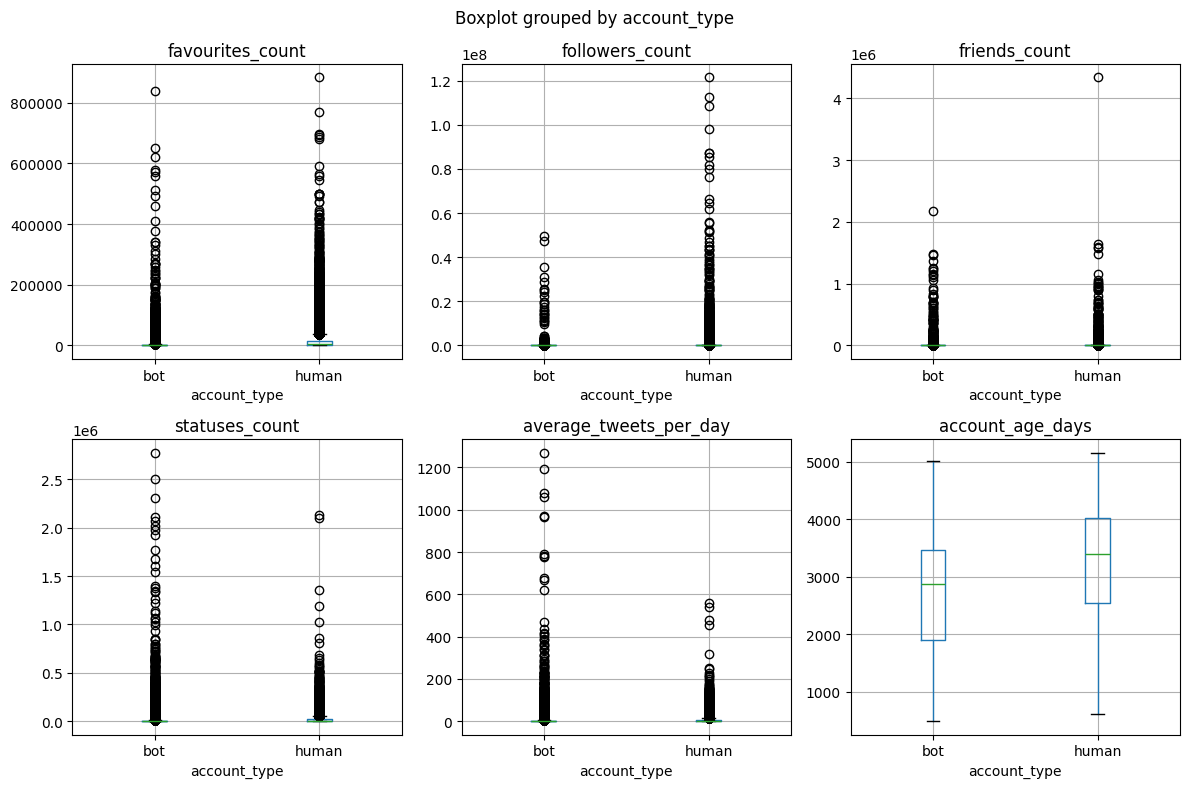

In [54]:
# Define the columns to include in the grid
num_columns = ['favourites_count', 'followers_count', 'friends_count', 'statuses_count', 'average_tweets_per_day', 'account_age_days']

# Create a grid of boxplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Iterate over the columns and plot the boxplot in the corresponding axis
for i, column in enumerate(num_columns):
    ax = axes[i // 3, i % 3]
    df.boxplot(column=column, ax=ax, by='account_type')
    ax.set_title(column)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

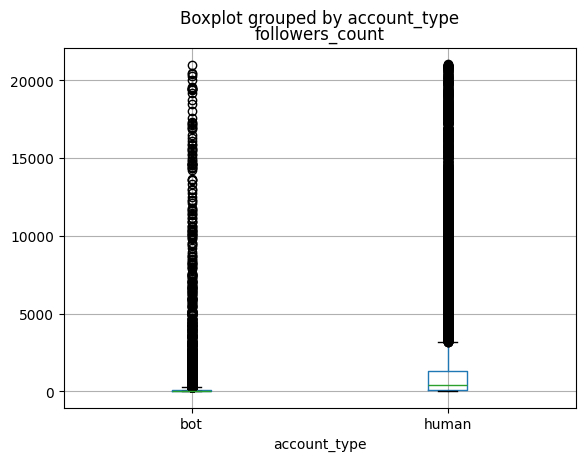

In [71]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['followers_count'].quantile(0.25)
Q3 = df['followers_count'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Determine the lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
filtered_df = df[(df["followers_count"] >= lower_bound) & (df["followers_count"] <= upper_bound)]

# Plot boxplot again
filtered_df.boxplot(column='followers_count', by='account_type')
plt.show()

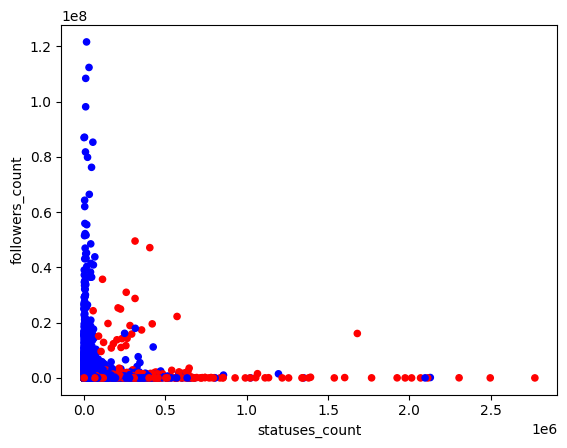

In [75]:
colors = {'bot': 'red', 'human': 'blue'}
df.plot.scatter(x='statuses_count', y='followers_count', c=df['account_type'].map(colors))
plt.show()